In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_squared_error, r2_score


In [3]:
data = pd.read_csv('../data/processed/aggregated_dataset.csv')
print("Cleaned dataset shape:", data.shape)
data.head()

Cleaned dataset shape: (40674, 1033)


,NLOS,RANGE,FP_IDX,FP_AMP1,FP_AMP2,FP_AMP3,STDEV_NOISE,CIR_PWR,MAX_NOISE,RXPACC,...,CIR1013,CIR1014,CIR1015,CIR_MEAN,CIR_VAR,CIR_SKEW,CIR_ENERGY_FIRST_100,CIR_PEAK_BIN,RISE_TIME,RISE_TIME_CLIPPED
0,0.0,3.90,745.0,18712.0,10250.0,11576.0,64.0,11855.0,967.0,611.0,...,505.0,307.0,0.0,395.225394,1.503746e+06,10.561181,22550.0,748,3.0,3.0
1,0.0,0.66,749.0,11239.0,6313.0,4712.0,64.0,18968.0,1133.0,447.0,...,89.0,103.0,0.0,444.060039,2.665030e+06,8.523565,20796.0,757,8.0,8.0
2,1.0,7.86,746.0,4355.0,5240.0,3478.0,60.0,14699.0,894.0,723.0,...,96.0,218.0,0.0,503.485236,1.859169e+06,7.101177,21061.0,754,8.0,8.0
3,1.0,3.48,750.0,8502.0,8416.0,5890.0,76.0,8748.0,1127.0,1024.0,...,155.0,342.0,256.0,413.054134,1.097226e+06,9.486008,26896.0,756,6.0,6.0
4,0.0,1.19,746.0,17845.0,18095.0,12058.0,68.0,11380.0,1744.0,276.0,...,247.0,292.0,256.0,363.357283,1.438949e+06,11.789746,21277.0,750,4.0,4.0


In [6]:
print("Data types for each column:")
print(data.dtypes)

# Print number of elements
print(f"Total number of elements: {data.size}")

# Print range of each numeric column
print("\nRange for each numeric column:")
for column in data.select_dtypes(include=[np.number]).columns:
    print(f"{column} range: {data[column].min()} to {data[column].max()}")

Data types for each column:
NLOS                    float64
RANGE                   float64
FP_IDX                  float64
FP_AMP1                 float64
FP_AMP2                 float64
                         ...   
CIR1015                 float64
CIR_MEAN                float64
CIR_VAR                 float64
CIR_SKEW                float64
CIR_ENERGY_FIRST_100    float64
Length: 1030, dtype: object
Total number of elements: 41897310

Range for each numeric column:
NLOS range: 0.0 to 1.0
RANGE range: 0.0 to 28.02
FP_IDX range: 707.0 to 848.0
FP_AMP1 range: 7.0 to 20572.0
FP_AMP2 range: 63.0 to 20624.0
FP_AMP3 range: 187.0 to 20577.0
STDEV_NOISE range: 28.0 to 220.0
CIR_PWR range: 0.0 to 31709.0
MAX_NOISE range: 310.0 to 5169.0
RXPACC range: 128.0 to 1056.0
CIR0 range: 2.0 to 844.0
CIR1 range: 3.0 to 912.0
CIR2 range: 1.0 to 916.0
CIR3 range: 0.0 to 997.0
CIR4 range: 1.0 to 1256.0
CIR5 range: 1.0 to 1012.0
CIR6 range: 1.0 to 1057.0
CIR7 range: 0.0 to 1007.0
CIR8 range: 0.0 to 895.0

In [7]:
print(data['NLOS'].value_counts(normalize=True))

NLOS
0.0    0.507043
1.0    0.492957
Name: proportion, dtype: float64


In [9]:
corr_matrix = data.corr()
nlos_corr = corr_matrix["NLOS"].sort_values(ascending=False)
print(nlos_corr.head(20))  # Top 20 positively correlated features
print(nlos_corr.tail(20))  # Top 20 negatively correlated features

NLOS                    1.000000
RXPACC                  0.728847
RANGE                   0.459524
CIR_ENERGY_FIRST_100    0.376700
CIR742                  0.322024
CIR741                  0.318421
CIR574                  0.280399
CIR740                  0.268005
CIR326                  0.266246
CIR646                  0.261291
CIR582                  0.259985
CIR575                  0.257203
CIR246                  0.257122
CIR526                  0.256469
CIR654                  0.255676
CIR590                  0.255246
CIR350                  0.255181
CIR430                  0.254694
CIR86                   0.254149
CIR598                  0.253306
Name: NLOS, dtype: float64
CIR758      -0.086166
CIR757      -0.116782
CIR747      -0.124435
CIR756      -0.154692
CIR748      -0.177664
CIR755      -0.196629
CIR754      -0.237659
CIR749      -0.241039
CIR753      -0.280543
CIR750      -0.302555
MAX_NOISE   -0.309440
CIR752      -0.318449
FP_IDX      -0.326559
CIR751      -0.335114
CIR_P

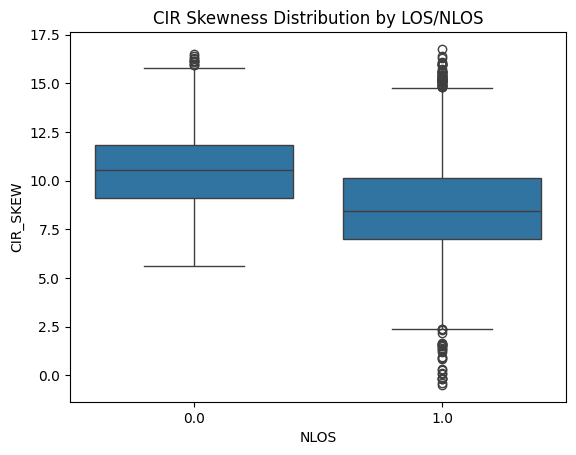

In [10]:
import seaborn as sns

# Example: CIR_SKEW vs. NLOS
sns.boxplot(x="NLOS", y="CIR_SKEW", data=data)
plt.title("CIR Skewness Distribution by LOS/NLOS")
plt.show()

<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:1: SyntaxWarning: invalid escape sequence '\d'
C:\Users\user\AppData\Local\Temp\ipykernel_4596\1333035497.py:1: SyntaxWarning: invalid escape sequence '\d'
  data['CIR_PEAK_BIN'] = data.loc[:, 'CIR0':'CIR1015'].idxmax(axis=1).str.extract('(\d+)').astype(int)


<Axes: xlabel='NLOS', ylabel='CIR_PEAK_BIN'>

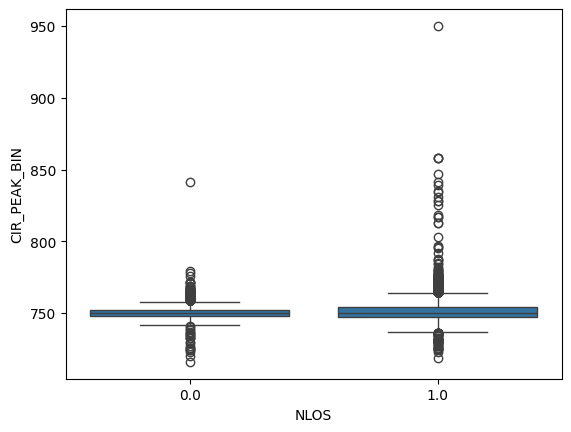

In [12]:
data['CIR_PEAK_BIN'] = data.loc[:, 'CIR0':'CIR1015'].idxmax(axis=1).str.extract('(\d+)').astype(int)
sns.boxplot(x='NLOS', y='CIR_PEAK_BIN', data=data)

In [6]:
# Calculate RISE_TIME
data['RISE_TIME'] = data['CIR_PEAK_BIN'] - data['FP_IDX']

# Filter invalid values
data = data[data['RISE_TIME'] >= 0]

# Clip outliers
rise_time_threshold = data['RISE_TIME'].quantile(0.99)
data['RISE_TIME_CLIPPED'] = data['RISE_TIME'].clip(upper=rise_time_threshold)

# Verify
data.to_csv('../data/processed/aggregated_dataset.csv', index=False)

In [9]:
print(data['RISE_TIME'].describe())

count    40674.000000
mean         5.194326
std          5.272344
min          0.000000
25%          2.000000
50%          4.000000
75%          7.000000
max        191.000000
Name: RISE_TIME, dtype: float64


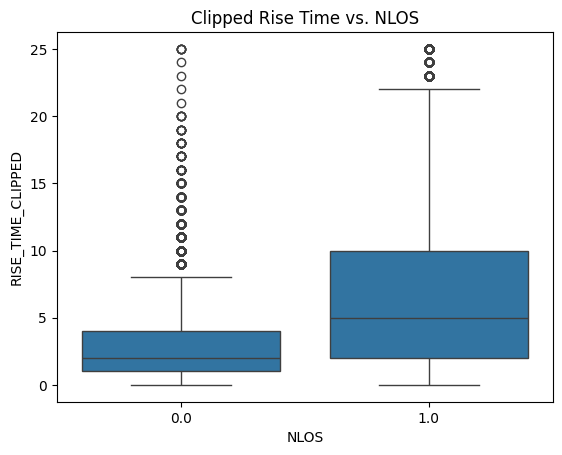

In [ ]:
sns.boxplot(x="NLOS", y="RISE_TIME_CLIPPED", data=data)
plt.title("Clipped Rise Time vs. NLOS")
plt.show()

In [8]:
from scipy.stats import ttest_ind
los_skew = data[data['NLOS'] == 0]['CIR_SKEW']
nlos_skew = data[data['NLOS'] == 1]['CIR_SKEW']
t_stat, p_value = ttest_ind(los_skew, nlos_skew)
print(f"p-value: {p_value:.4f}")  # Expect p < 0.05

p-value: 0.0000


In [ ]:
# from sklearn.preprocessing import RobustScaler  # Handles outliers better than StandardScaler
# scaler = RobustScaler()
# X_scaled = scaler.fit_transform(X)

NameError: name 'X' is not defined

In [ ]:
# step 3: split data into features and labels
# features (exclude NLOS and RANGE)
X = data.drop(columns=['NLOS', 'RANGE'])

y_class = data['NLOS']  # label (0 = LOS, 1 = NLOS)
y_reg = data['RANGE']

In [ ]:
# step 4: split data into training and testing Sets
# split for classification (stratified split)
X_train, X_test, y_class_train, y_class_test = train_test_split(
    X, y_class,
    test_size=0.3,
    stratify=y_class,
    random_state=42
)

# split for regression (same indices using random_state=42)
_, _, y_reg_train, y_reg_test = train_test_split(
    X, y_reg,
    test_size=0.3,
    random_state=42
)

# verify shapes
print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

In [ ]:
# scaler = StandardScaler()  # Default: StandardScaler
scaler = MinMaxScaler()   # Alternative: MinMaxScaler

# Scale features
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
clf = RandomForestClassifier(random_state=42)

# Define parameter grid for tuning
param_grid_clf = {
    'n_estimators': [100, 200],     # Number of trees
    'max_depth': [None, 10, 20],    # Tree depth
    'min_samples_split': [2, 5]     # Minimum samples to split
}

# Initialize GridSearchCV with stratified cross-validation
grid_search_clf = GridSearchCV(
    clf,
    param_grid_clf,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),  # CUSTOMIZE FOLDS HERE
    scoring='accuracy',
    n_jobs=-1
)

# Fit to scaled training data
grid_search_clf.fit(X_train_scaled, y_class_train)

# Best model
best_clf = grid_search_clf.best_estimator_
print("Best Parameters (Classification):", grid_search_clf.best_params_)

In [ ]:
# Evaluate on test set
y_class_pred = best_clf.predict(X_test_scaled)
accuracy = accuracy_score(y_class_test, y_class_pred)
print(f"\nTest Accuracy: {accuracy:.2f}")
print(classification_report(y_class_test, y_class_pred))

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_class_test, y_class_pred), annot=True, fmt='d', cmap='Blues', 
            xticklabels=['LOS', 'NLOS'], yticklabels=['LOS', 'NLOS'])
plt.title('Confusion Matrix (Classification)')
plt.show()

In [ ]:
reg = RandomForestRegressor(random_state=42)

# Define parameter grid for tuning
param_grid_reg = {
    'n_estimators': [100, 200],     # Number of trees
    'max_depth': [None, 10, 20],    # Tree depth
    'min_samples_split': [2, 5]     # Minimum samples to split
}

# Initialize GridSearchCV with standard cross-validation
grid_search_reg = GridSearchCV(
    reg,
    param_grid_reg,
    cv=KFold(n_splits=5, shuffle=True, random_state=42),  # CUSTOMIZE FOLDS HERE
    scoring='neg_root_mean_squared_error',  # Metric: RMSE
    n_jobs=-1
)

# Fit to scaled training data
grid_search_reg.fit(X_train_scaled, y_reg_train)

# Best model
best_reg = grid_search_reg.best_estimator_
print("Best Parameters (Regression):", grid_search_reg.best_params_)

In [ ]:
# Evaluate on test set
y_reg_pred = best_reg.predict(X_test_scaled)
rmse = np.sqrt(mean_squared_error(y_reg_test, y_reg_pred))
r2 = r2_score(y_reg_test, y_reg_pred)
print(f"\nTest RMSE: {rmse:.2f}")
print(f"Test R² Score: {r2:.2f}")

# Plot predicted vs actual
plt.figure(figsize=(8, 6))
plt.scatter(y_reg_test, y_reg_pred, alpha=0.3)
plt.plot([y_reg_test.min(), y_reg_test.max()], [y_reg_test.min(), y_reg_test.max()], 'k--', lw=2)
plt.xlabel('Actual Range')
plt.ylabel('Predicted Range')
plt.title('Actual vs Predicted Range')
plt.show()


In [ ]:
# # step 5: train random forest models
# # initialize models

# rf_classifier = RandomForestClassifier(
#     n_estimators=100,
#     random_state=42,
#     n_jobs=-1
# )

# rf_regressor = RandomForestRegressor(
#     n_estimators=100,
#     random_state=42,
#     n_jobs=-1
# )

# # train models
# rf_classifier.fit(X_train, y_class_train)
# rf_regressor.fit(X_train, y_reg_train)

In [ ]:
# # step 6: evaluate models
# # predict on test set
# y_class_pred = rf_classifier.predict(X_test)

# # calculate metrics 
# accuracy = accuracy_score(y_class_test, y_class_pred)
# report = classification_report(y_class_test, y_class_pred)
# cm = confusion_matrix(y_class_test, y_class_pred)

# print(f"Classification Accuracy: {accuracy:.2f}")
# print("\nClassification Report:\n", report)

# # plot confusion matrix
# plt.figure(figsize=(6, 4))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['LOS', 'NLOS'], yticklabels=['LOS', 'NLOS'])
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title('Confusion Matrix')
# plt.show()

In [ ]:
# regression metrics
# predict on test set
y_reg_pred = rf_regressor.predict(X_test)

# calculate metrics
rmse = np.sqrt(mean_squared_error(y_reg_test, y_reg_pred))
r2 = r2_score(y_reg_test, y_reg_pred)

print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

# plot predicted vs actual
plt.figure(figsize=(8, 6))
plt.scatter(y_reg_test, y_reg_pred, alpha=0.3)
plt.plot([y_reg_test.min(), y_reg_test.max()], [y_reg_test.min(), y_reg_test.max()], 'k--', lw=2)
plt.xlabel('Actual Range')
plt.ylabel('Predicted Range')
plt.title('Actual vs Predicted Range')
plt.show()

In [ ]:
# step 7: feature importance analysis
# get feature importances
feature_importances_class = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_classifier.feature_importances_
}).sort_values('Importance', ascending=False)

feature_importances_reg = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_regressor.feature_importances_
}).sort_values('Importance', ascending=False)

# plot classification feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances_class.head(10))
plt.title('Top 10 Features for LOS/NLOS Classification')
plt.show()

# plot regression feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances_reg.head(10))
plt.title('Top 10 Features for Range Prediction')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score

# Predict on the test set
y_pred = rf_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_class_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")